<a href="https://colab.research.google.com/github/aghakishiyeva/Explainable-Techniques/blob/main/AIPI590_Assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in? Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/aghakishiyeva/Explainable-Techniques/tree/main)

### Installing and Importing Necessary Libraries

Firstly, we install and import the necessary libraries. We use **torch** and **torchvision** for loading the pre-trained ResNet34 model, **lime** for generating explanations, and **matplotlib** for visualizing the results.

In [7]:
!pip install torch torchvision lime matplotlib

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3070, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2863, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_in

In [15]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torchvision import transforms
from PIL import Image
from lime import lime_image
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

### Loading CIFAR-10 Dataset and Extracting a Dog Image

Next, we load the CIFAR-10 dataset using torchvision.datasets. The CIFAR-10 dataset contains 10 classes, one of which is the "dog" class (with label 5). We loop through the dataset and display the first image that belongs to the dog class.

100%|██████████| 170498071/170498071 [00:02<00:00, 72803002.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


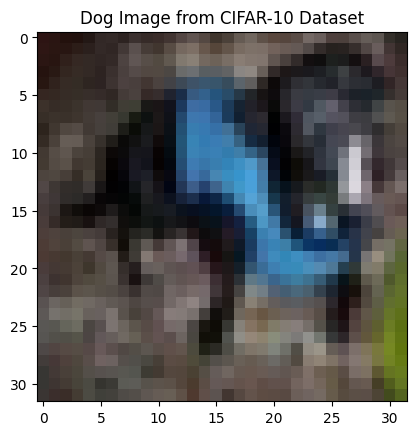

In [6]:
# Define transformation to convert image to tensor
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='./data', download=True, transform=transform)

# Find and display the first dog image in the dataset (dog class is index 5)
for img, label in cifar10:
    if label == 5:  # 5 is the label for 'dog' in CIFAR-10
        plt.imshow(img.permute(1, 2, 0))  # Rearrange dimensions for plotting
        plt.title("Dog Image from CIFAR-10 Dataset")
        plt.show()
        break


### Loading Pre-trained ResNet34 and Setting Up Preprocessing

Here, we load the ResNet34 model, which is pre-trained on ImageNet. We define a preprocessing pipeline to resize the CIFAR-10 images to 224x224 pixels (as required by ResNet34) and normalize them according to the ImageNet mean and standard deviation. The dog image from the previous step is then preprocessed.

In [8]:
import torch
import torchvision.models as models
from torchvision import transforms

# Load a pre-trained ResNet34 model
model = models.resnet34(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define preprocessing function for CIFAR-10 images (Resize, Normalize)
preprocess = transforms.Compose([
    transforms.Resize(224),  # ResNet expects 224x224 images
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing to the selected dog image
img_preprocessed = preprocess(img)  # Apply normalization and resizing
img_preprocessed = img_preprocessed.unsqueeze(0)  # Add batch dimension

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 75.7MB/s]


### Defining the Prediction Function

In this cell, we define the predict function for LIME. This function takes the preprocessed image batch, passes it through the ResNet34 model, and returns the softmax probabilities for each class. The softmax output represents the probability distribution over the possible classes.

In [12]:
# Define a prediction function for LIME
def predict(img_batch):
    # Convert the NumPy image batch back to a torch tensor
    img_batch = torch.tensor(img_batch).permute(0, 3, 1, 2).float()  # Rearrange dimensions
    img_batch = preprocess(img_batch)  # Apply the same preprocessing as before
    with torch.no_grad():
        logits = model(img_batch)
    return logits.softmax(dim=1).cpu().numpy()  # Return NumPy array

### Setting Up LIME Explainer and Generate Explanation

Here, we initialize the LIME explainer for image data. We convert the dog image to a NumPy array format (since LIME requires NumPy arrays) and then generate an explanation for the model’s top prediction.

In [13]:
# Initialize LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Convert the image to a NumPy array (required by LIME)
img_numpy = img.permute(1, 2, 0).numpy()  # Rearrange tensor to image format

# Generate explanation for the model's prediction
explanation = explainer.explain_instance(img_numpy, predict, top_labels=1, hide_color=0)


  0%|          | 0/1000 [00:00<?, ?it/s]

### Visualizing the Explanation

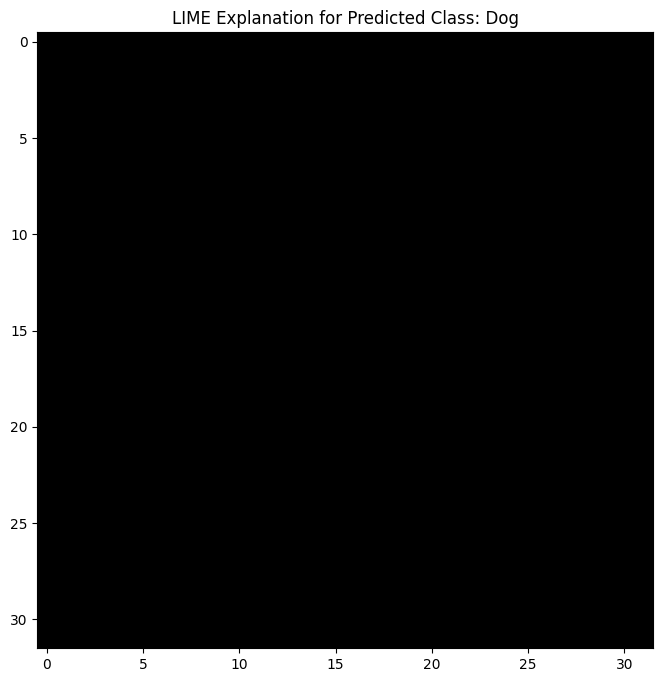

In [16]:
# Visualize the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp / 255.0, mask)

# Plot the result
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(img_boundry)
ax.set_title("LIME Explanation for Predicted Class: Dog")
plt.show()

### **Discussion on Explanation Technique**


I chose **LIME** for this assignment because it provides clear, interpretable visual explanations for individual predictions. LIME works by perturbing parts of the image and analyzing how those changes affect the model’s prediction, making it useful for image classification tasks.

### Strengths:
- LIME is model-agnostic, meaning it can explain any model, including blackbox models like ResNet34.
- It produces local explanations that help understand individual predictions.
- The visual explanations are intuitive and easy to interpret, especially for image data.

### Limitations:
- LIME relies on perturbing the input image, which can sometimes miss important feature interactions.
- It can be slow when applied to larger images or deeper models, due to the number of perturbations required.

### Potential Improvements:
- Using **SHAP** instead of LIME could provide more consistent explanations based on Shapley values, which are more theoretically grounded.
- Combining LIME with **Anchors** could offer more rule-based explanations alongside the visual ones, leading to better interpretability.
